In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio import plot
import rasterio

SQLalchemy is not installed. No support for SQL output.


In [3]:
sm = stepmodel.read_zippedpickles(r'../../model/{scen}/assignment'.format(scen=scenario))
raster = rasterio.open(r'../../inputs/tiff/20137.tiff', )

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 14.08it/s]


# stacks

In [4]:
# simple example
sm.stack_routes = sm.links.groupby(['route_id'])['boardings'].sum()

In [5]:
# links
sm.links['volume'] = sm.links['pt']
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)

In [6]:
# path sum
df = sm.los
df['length'] = 1000 #TODO : change that dist. vol d'oiseau
df['voy_hour'] = df['time'] * df['volume'] / 3600
df['voy_km'] = df['length'] * df['volume'] / 1000
stack = sm.los.groupby('route_type')[['volume', 'voy_hour', 'voy_km']].sum().stack()
stack.index.names = ['route_type', 'indicator']
stack.name = 'sum'
sm.stack_path_sum = stack
stack # stack is a series with a hierarchical index

route_type  indicator
car         volume        8755.186144
            voy_hour       741.784897
            voy_km        8755.186144
pt          volume       33844.516663
            voy_hour     11284.305074
            voy_km       33844.516663
walk        volume       53645.314866
            voy_hour     18652.788090
            voy_km       53645.314866
Name: sum, dtype: float64

In [7]:
# all attrs from sm starting with 'stack' will be dumped to the filepath a an unique excel file
sm.to_excel(filepath='../../model/{scen}/summaries.xlsx'.format(scen=scenario), prefix='stack')

# maps

In [8]:
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.pyplot as plt

from syspy.syspy_utils.data_visualization import base_plot, width_series, linewidth_from_data_units
from syspy.syspy_utils.data_visualization import geometry
def bandwidth(
    gdf, value_column, max_value=None, power=1, legend=True, legend_values=None, legend_length=1 / 3,
    label_column=None, max_linewidth_meters=100, variable_width=True, line_offset=True, cmap='Spectral',
    geographical_bounds=None, label_kwargs={'size': 12}, *args, **kwargs
):
    # TODO:
    # 1. add to plot model
    # 2. add arrows?

    # Can only plot valid LineString
    df = gdf[gdf.length > 0].sort_values(value_column).copy()
    df = df[df.geometry.type == 'LineString']


    plot = base_plot(df, geographical_bounds, *args, **kwargs)

    divider = make_axes_locatable(plot)
    cax = divider.append_axes('right', size="2%", pad=0.05)
    
    # Plot values
    # Power scale
    df['power'] = np.power(df[value_column], power)
    power_max_value = np.power(max_value, power) if max_value else df['power'].max()
    # Linewidth
    df['geographical_width'] = width_series(df['power'], max_linewidth_meters, max_value=power_max_value)
    df['linewidth'] = linewidth_from_data_units(df['geographical_width'].values, plot)
    # Offset
    if line_offset:
        df['geometry'] = df.apply(
            lambda x: x['geometry'].parallel_offset(x['geographical_width'] * 0.5, 'right'), 1
        )
        df = df[df.geometry.type == 'LineString']
        df = df[df.length > 0]  # offset can create empty LineString
        # For some reason, right offset reverse the coordinates sequence
        # https://github.com/Toblerity/Shapely/issues/284
        df['geometry'] = df.geometry.apply(lambda x: geometry.LineString(x.coords[::-1]))
    # Plot
    #return df
    df.plot(column=value_column, linewidth=df['linewidth'], ax=plot, legend=True, cax=cax, cmap=cmap)
    plot.set_yticks([])
    plot.set_xticks([])
    return plot

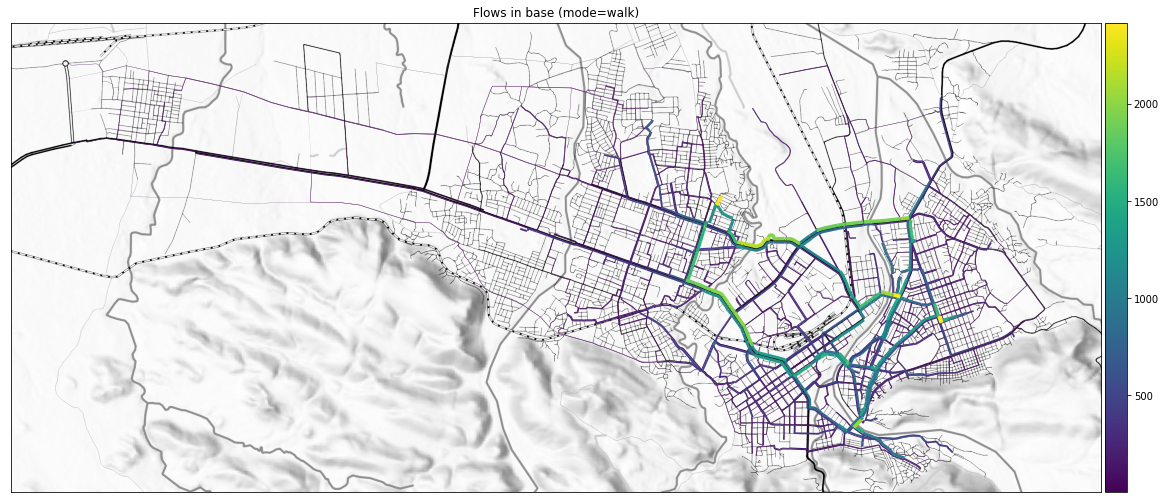

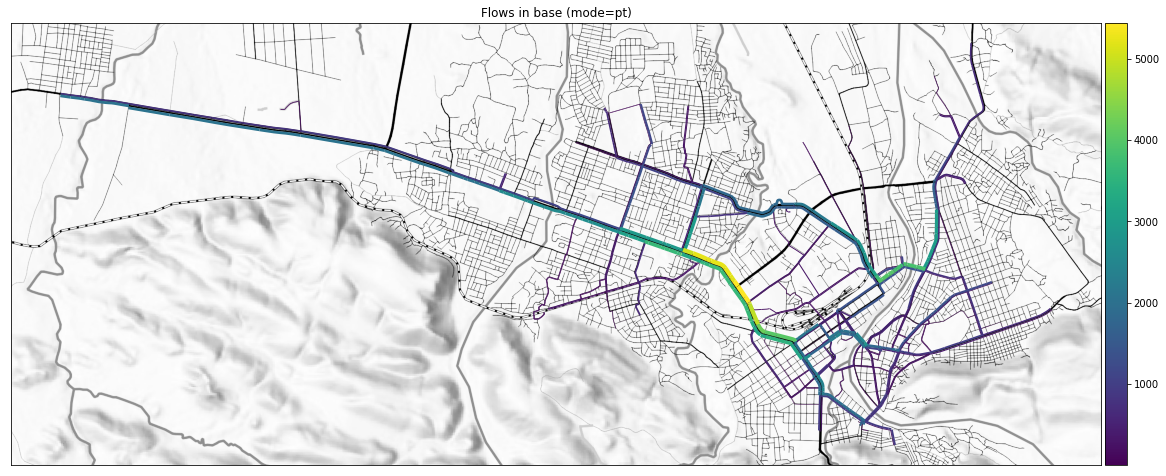

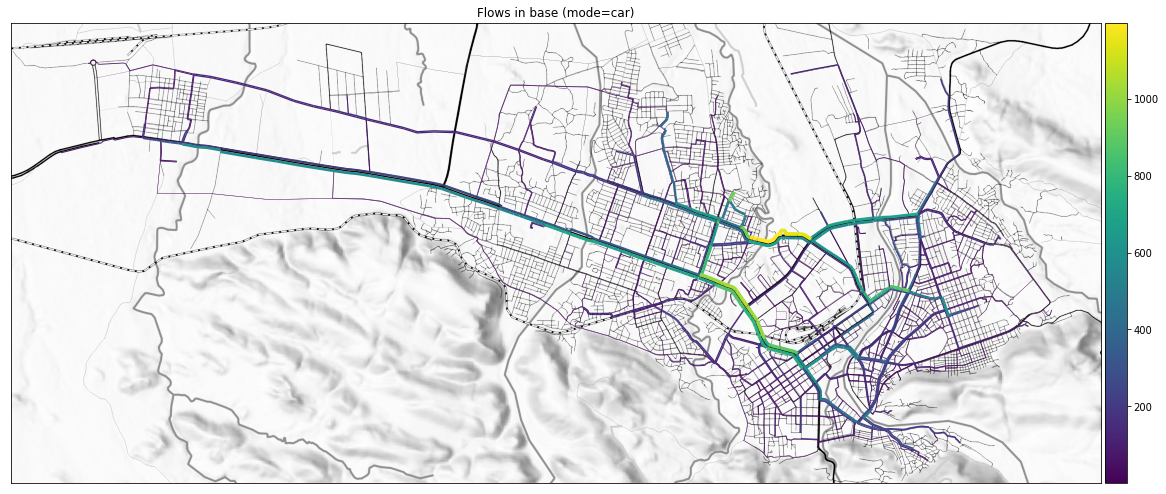

In [9]:
for column in ['walk', 'pt', 'car']:
    l = sm.road_links
    l = l.loc[l[column]>0]
    ax = bandwidth(l, column, figsize=(20,  10), legend=True, cmap='viridis', max_linewidth_meters=50, power=0.5)
    #add_raster(plot, raster, adjust=None, cmap='Greys_r')
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    rasterio.plot.show(raster, ax=ax, adjust=None, cmap='Greys_r', with_bounds=True)
    if True:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    ax.set_title('Flows in {scen} (mode={mode})'.format(mode=column, scen=scenario))
    fig = ax.get_figure()
    fig.savefig('../../outputs/assignment_{mode}_{scen}.png'.format(mode=column, scen=scenario), bbox_inches='tight')

In [10]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined